# **Transfer Learning**
Pre-trained models can be used for *image classification, feature extraction*, and *transfer learning*. There are four popular pre-trained models:
*   VGG16: CNN model for image recognition with 16 weight layers
*   VGG19: CNN model for image recognition with 19 weight layers
*   InceptionV3
*   ResNet50

Transfer learning allowed you to use pre-trained model and customize it. It is used for large scale data, then you can save time by using learned feature maps without start from the beginning.

1.   **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
  - "bottleneck layer", the last layer before flatten operation is chosen as the layer for feature extraction.
2.   **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model.

**Procedures**

1) Take layers from a previously trained model
*   When downloading a pretrained model, ignore the top layer by `include_top = False`

2) Freeze them,so as to avoid destroying any information they contained during future training
*   All pretrained layers aren't trained so that we freeze them by `layer.trainable = False`

3) Add some new layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.

4) Train the new layers on your dataset
*   If model overfits the training data, add a dropout layer



In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-31 18:13:08--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.197.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   170MB/s    in 0.5s    

2020-07-31 18:13:09 (170 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#1) Take layers from a previously trained model
#Load pretrained model and weights
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
								    include_top = False, # don't include the top layers
								    weights = None)
pre_trained_model.load_weights(local_weights_file)


#2) Freeze them,so as to avoid destroying any information they contained during future training
for layer in pre_trained_model.layers:
	layer.trainable = False 

#pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output #feature extraction

last layer output shape:  (None, 7, 7, 768)


The layer we will use for feature extraction in Inception v3 is called mixed7. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from mixed7:

In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-07-31 18:13:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   228MB/s    in 0.3s    

2020-07-31 18:13:16 (228 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Extract Zip
zip = zipfile.ZipFile('/tmp/cats_and_dogs_filtered.zip', 'r')
zip.extractall('/tmp')
zip.close()

#Define directories and image files
train_dir = os.path.join( '/tmp/cats_and_dogs_filtered', 'train')
validation_dir = os.path.join( '/tmp/cats_and_dogs_filtered', 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen/test_datagen generator
train_generator = train_datagen.flow_from_directory( train_dir, # Source directory for training images
                                                     batch_size = 20,
                                                     class_mode = 'binary',  # Since we use binary_crossentropy loss, we need binary labels
                                                     target_size = (150, 150)) # All images will be resized to 150x150    
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
###double checking feature extraction from pre-trained model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np


img_path = '/tmp/cats_and_dogs_filtered/train/cats/cat.10.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = pre_trained_model.predict(img_data)

print(vgg16_feature.shape)

(1, 3, 3, 2048)


In [ ]:
#3) Add some new classifier layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2                 
x = layers.Dense  (1, activation='sigmoid')(x) # Add a final sigmoid layer for classification          

#configure and compile the model
model = Model(pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [59]:
#4) Train the new layers on your dataset.
#model.fit_generator
"""history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100, # len(train)/batch_size
            epochs = 20,
            validation_steps = 50, # len(validation)/batch_size
            verbose = 2)"""
history = model.fit(train_generator, 
          validation_data=validation_generator,
          steps_per_epoch = 100, # len(train)/batch_size
          epochs = 20,
          validation_steps = 50, # len(validation)/batch_size
          verbose = 2)

Epoch 1/20
100/100 - 156s - loss: 0.3628 - acc: 0.8585 - val_loss: 0.1024 - val_acc: 0.9600
Epoch 2/20
100/100 - 153s - loss: 0.2299 - acc: 0.9145 - val_loss: 0.1035 - val_acc: 0.9560
Epoch 3/20
100/100 - 152s - loss: 0.2018 - acc: 0.9215 - val_loss: 0.1786 - val_acc: 0.9400
Epoch 4/20
100/100 - 155s - loss: 0.2150 - acc: 0.9265 - val_loss: 0.1149 - val_acc: 0.9640
Epoch 5/20
100/100 - 153s - loss: 0.1951 - acc: 0.9325 - val_loss: 0.1193 - val_acc: 0.9570
Epoch 6/20
100/100 - 153s - loss: 0.1790 - acc: 0.9335 - val_loss: 0.2456 - val_acc: 0.9330
Epoch 7/20
100/100 - 152s - loss: 0.1883 - acc: 0.9395 - val_loss: 0.1222 - val_acc: 0.9610
Epoch 8/20
100/100 - 158s - loss: 0.1643 - acc: 0.9445 - val_loss: 0.1087 - val_acc: 0.9680
Epoch 9/20
100/100 - 154s - loss: 0.1539 - acc: 0.9450 - val_loss: 0.1131 - val_acc: 0.9630
Epoch 10/20
100/100 - 158s - loss: 0.1791 - acc: 0.9455 - val_loss: 0.1142 - val_acc: 0.9620
Epoch 11/20
100/100 - 154s - loss: 0.1658 - acc: 0.9415 - val_loss: 0.1857 - va

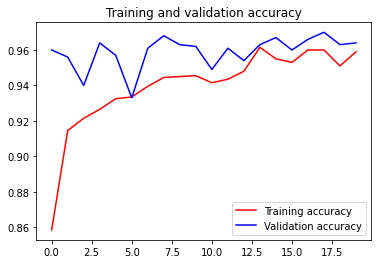

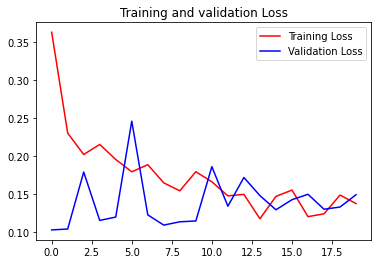

<Figure size 432x288 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

# **Further Improvement using Fine-tuning**
In feature-extraction, we only added two classification layers on top of an Inception V3 layer. The weights of pretrained network were not updated during training.
- attemp after you have trained the top-lavel classifier with the pretrained model set to non-trainable.
- fine-tune only the top layers of the pre-trained model


Let's unfreeze all layers belonging to the mixed7 module—i.e., all layers found after mixed6—and recompile the model:

In [ ]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

#Unfreeze all model after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.00001, momentum=0.9),
              metrics=['acc'])

#Retrain the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/20
100/100 - 173s - loss: 0.1496 - acc: 0.9385 - val_loss: 0.1396 - val_acc: 0.9580
Epoch 2/20
100/100 - 172s - loss: 0.1662 - acc: 0.9365 - val_loss: 0.1394 - val_acc: 0.9590
Epoch 3/20
100/100 - 171s - loss: 0.1509 - acc: 0.9405 - val_loss: 0.1380 - val_acc: 0.9590
Epoch 4/20
100/100 - 173s - loss: 0.1650 - acc: 0.9320 - val_loss: 0.1371 - val_acc: 0.9590
Epoch 5/20


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

- **Questions**
    - If you use a dropout parameter of 0.2, how many nodes will you lose?
        - 20% of them.
    - Why is transfer learning useful?
        - Because I can use the features that were learned from large datasets that I may no have access to.
    - How do you lock of freeze a layer from retraining?
        - Set the layer's trainable attribute to False: `layer.trainable=False`
    - How do you change the number of classes the model can classify when using transfer learning? (e.g. the original model handled 1000 classes, but your handles just 2)
        - When you add your DNN at the bottom of the network, you specify your output layer with the number of classes you want. E.g. `tf.keras.layers.Dense(1, activation='sigmoid')` for binary classification.
    - Can you use Image Augmentation with Transfer Learning Models?
        - Yes, because you are adding new layers at the bottom of the network, and you can use image augmentation when training these.
    - Why do dropouts help avoid overfitting?
        - Because neighbouring neurons can have similar weights, and thus can skew the final training.
    - What would the symptom of a Dropout rate being set too high?
        - The network would lose specialization down the effect that it would be inefficient or ineffective at learning, driving accuracy down.
    - How would you add a dropout layer to dropout 20% of neurons using TensorFlow?
        - `tf.keras.layers.Dropout(0.2)`
- 🚫 Noticing the average viewership of different learning materials reduces with each major section, e.g. Week 1, part 1 had 10,000+ but Week 3, part 2 has ~2,000. Meaning, people either use the free-trial then dropout or the longer you commit, the more knowledge you'll gain over others.
- 🚫 Grader failed on the programming assignment again, don't really care (the code matters more), moving onto the next module.